# **Challenge Telecom X: análisis de evasión de clientes - Parte 2**

## Glosario de Variables

### Información del Cliente
- `customerID`: Identificador único para cada cliente
- `gender`: Género del cliente (masculino/femenino)
- `SeniorCitizen`: Indicador si el cliente es mayor de 65 años
- `Partner`: Indicador si el cliente tiene pareja
- `Dependents`: Indicador si el cliente tiene personas dependientes
- `tenure`: Duración de la relación con el cliente en meses

### Servicios Contratados
- `PhoneService`: Servicio de telefonía básica
- `MultipleLines`: Contratación de líneas adicionales
- `InternetService`: Tipo de servicio de internet
- `OnlineSecurity`: Servicio adicional de seguridad en línea
- `OnlineBackup`: Servicio de respaldo en la nube
- `DeviceProtection`: Protección para dispositivos
- `TechSupport`: Soporte técnico prioritario
- `StreamingTV`: Servicio de televisión por streaming
- `StreamingMovies`: Servicio de películas por streaming

### Información de Facturación
- `Contract`: Tipo de contrato
- `PaperlessBilling`: Facturación digital
- `PaymentMethod`: Método de pago
- `Charges.Monthly`: Cargo mensual total
- `Charges.Total`: Monto total facturado

### Variable Objetivo
- `Churn`: Indicador de abandono del servicio

In [38]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

import pickle

# 📥 Fase de Extracción de Datos

En esta sección inicial, nos enfocaremos en la obtención y carga de los datos desde la fuente original. Utilizaremos las bibliotecas pandas y numpy para manejar eficientemente los datos.

In [39]:
datos = pd.read_csv('/content/datos_totales.csv')
datos

,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,Cuentas_Diarias,total_services
0,0002-ORFBO,0,Female,0,1,1,9,1,0,1,0,1,0,1,1,0,One year,1,Mailed check,65.60,593.30,2.186667,4
1,0003-MKNFE,0,Male,0,0,0,9,1,1,1,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.90,542.40,1.996667,3
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,1,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.90,280.85,2.463333,2
3,0011-IGKFF,1,Male,1,1,0,13,1,0,1,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.00,1237.85,3.266667,5
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,1,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.90,267.40,2.796667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7251,9987-LUTYD,0,Female,0,0,0,13,1,0,1,1,0,0,1,0,0,One year,0,Mailed check,55.15,742.90,1.838333,3
7252,9992-RRAMN,1,Male,0,1,0,22,1,1,1,0,0,0,0,0,1,Month-to-month,1,Electronic check,85.10,1873.70,2.836667,3
7253,9992-UJOEL,0,Male,0,0,0,2,1,0,1,0,1,0,0,0,0,Month-to-month,1,Mailed check,50.30,92.75,1.676667,2
7254,9993-LHIEB,0,Male,0,1,1,67,1,0,1,1,0,1,1,0,1,Two year,0,Mailed check,67.85,4627.65,2.261667,5


In [40]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7256 non-null   object 
 1   churn                      7256 non-null   int64  
 2   customer_gender            7256 non-null   object 
 3   customer_seniorcitizen     7256 non-null   int64  
 4   customer_partner           7256 non-null   int64  
 5   customer_dependents        7256 non-null   int64  
 6   customer_tenure            7256 non-null   int64  
 7   phone_phoneservice         7256 non-null   int64  
 8   phone_multiplelines        7256 non-null   int64  
 9   internet_internetservice   7256 non-null   int64  
 10  internet_onlinesecurity    7256 non-null   int64  
 11  internet_onlinebackup      7256 non-null   int64  
 12  internet_deviceprotection  7256 non-null   int64  
 13  internet_techsupport       7256 non-null   int64

In [41]:
datos.describe()

,churn,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_paperlessbilling,account_charges_monthly,account_charges_total,Cuentas_Diarias,total_services
count,7256.000000,7256.0000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000
mean,0.257580,0.1629,0.483600,0.299063,32.395535,0.902839,0.421858,0.782938,0.285832,0.344542,0.342751,0.289416,0.383958,0.387955,0.593716,64.755423,2280.634213,2.158514,3.359151
std,0.437332,0.3693,0.499765,0.457879,24.558067,0.296197,0.493890,0.412273,0.451841,0.475252,0.474662,0.453522,0.486381,0.487318,0.491173,30.125739,2268.632997,1.004191,2.062766
min,0.000000,0.0000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.608333,0.000000
25%,0.000000,0.0000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.450000,400.225000,1.181667,1.000000
50%,0.000000,0.0000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.300000,1391.000000,2.343333,3.000000
75%,1.000000,0.0000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.900000,3785.300000,2.996667,5.000000
max,1.000000,1.0000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,3.958333,8.000000


# 🔄 Fase de Transformación

En esta etapa, realizaremos la limpieza y preparación de los datos:
- Normalización de nombres de columnas
- Tratamiento de valores faltantes
- Estandarización de formatos
- Creación de variables derivadas

Elimina columnas que no aportan valor al análisis o a los modelos predictivos, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.

In [42]:
datos = datos.drop(['customerid'], axis=1)

In [43]:
datos

,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,Cuentas_Diarias,total_services
0,0,Female,0,1,1,9,1,0,1,0,1,0,1,1,0,One year,1,Mailed check,65.60,593.30,2.186667,4
1,0,Male,0,0,0,9,1,1,1,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.90,542.40,1.996667,3
2,1,Male,0,0,0,4,1,0,1,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.90,280.85,2.463333,2
3,1,Male,1,1,0,13,1,0,1,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.00,1237.85,3.266667,5
4,1,Female,1,1,0,3,1,0,1,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.90,267.40,2.796667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7251,0,Female,0,0,0,13,1,0,1,1,0,0,1,0,0,One year,0,Mailed check,55.15,742.90,1.838333,3
7252,1,Male,0,1,0,22,1,1,1,0,0,0,0,0,1,Month-to-month,1,Electronic check,85.10,1873.70,2.836667,3
7253,0,Male,0,0,0,2,1,0,1,0,1,0,0,0,0,Month-to-month,1,Mailed check,50.30,92.75,1.676667,2
7254,0,Male,0,1,1,67,1,0,1,1,0,1,1,0,1,Two year,0,Mailed check,67.85,4627.65,2.261667,5


# **Correlacion y seleccion de variables**

## **Encoding**

Transforma las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning. Utiliza un método de codificación adecuado, como **[one-hot encoding](https://www.google.com/url?q=https%3A%2F%2Fscikit-learn.org%2Fstable%2Fmodules%2Fgenerated%2Fsklearn.preprocessing.OneHotEncoder.html)**.

**¿Por qué usar OneHotEncoder?**

pd.get_dummies es muy útil y directo para codificación rápida, pero OneHotEncoder ofrece más control, especialmente cuando vas a usar tus datos en modelos de machine learning con Scikit-Learn, ya que:

- Es compatible con pipelines de procesamiento.

- Permite codificar datos de prueba con las mismas columnas del entrenamiento.

- Puedes configurarlo para devolver matrices densas o dispersas (sparse).

- Puedes recuperar el nombre de las columnas codificadas fácilmente.

## **Variables categoricas**

In [44]:
variables_categoricas = [
    'customer_gender',
    'customer_partner',
    'customer_dependents',
    'internet_internetservice',
    'account_contract',
    'account_paperlessbilling',
    'account_paymentmethod'
]

In [45]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     variables_categoricas),
    remainder='passthrough')

In [46]:
datos_OneHotEncoder = one_hot_encoder.fit_transform(datos)
datos_OneHotEncoder = pd.DataFrame(datos_OneHotEncoder, columns=one_hot_encoder.get_feature_names_out())
datos_OneHotEncoder

,onehotencoder__customer_gender_Female,onehotencoder__customer_gender_Male,onehotencoder__customer_partner_0,onehotencoder__customer_partner_1,onehotencoder__customer_dependents_0,onehotencoder__customer_dependents_1,onehotencoder__internet_internetservice_0,onehotencoder__internet_internetservice_1,onehotencoder__account_contract_Month-to-month,onehotencoder__account_contract_One year,onehotencoder__account_contract_Two year,onehotencoder__account_paperlessbilling_0,onehotencoder__account_paperlessbilling_1,onehotencoder__account_paymentmethod_Bank transfer,onehotencoder__account_paymentmethod_Credit card,onehotencoder__account_paymentmethod_Electronic check,onehotencoder__account_paymentmethod_Mailed check,remainder__churn,remainder__customer_seniorcitizen,remainder__customer_tenure,remainder__phone_phoneservice,remainder__phone_multiplelines,remainder__internet_onlinesecurity,remainder__internet_onlinebackup,remainder__internet_deviceprotection,remainder__internet_techsupport,remainder__internet_streamingtv,remainder__internet_streamingmovies,remainder__account_charges_monthly,remainder__account_charges_total,remainder__Cuentas_Diarias,remainder__total_services
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,65.60,593.30,2.186667,4.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,59.90,542.40,1.996667,3.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,73.90,280.85,2.463333,2.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,13.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,98.00,1237.85,3.266667,5.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.90,267.40,2.796667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7251,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,55.15,742.90,1.838333,3.0
7252,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,85.10,1873.70,2.836667,3.0
7253,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.30,92.75,1.676667,2.0
7254,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,67.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,67.85,4627.65,2.261667,5.0


In [47]:
datos_OneHotEncoder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 32 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   onehotencoder__customer_gender_Female                  7256 non-null   float64
 1   onehotencoder__customer_gender_Male                    7256 non-null   float64
 2   onehotencoder__customer_partner_0                      7256 non-null   float64
 3   onehotencoder__customer_partner_1                      7256 non-null   float64
 4   onehotencoder__customer_dependents_0                   7256 non-null   float64
 5   onehotencoder__customer_dependents_1                   7256 non-null   float64
 6   onehotencoder__internet_internetservice_0              7256 non-null   float64
 7   onehotencoder__internet_internetservice_1              7256 non-null   float64
 8   onehotencoder__account_contract_Month-to-month  

## **Matriz de correlacion**

In [48]:
corr = datos_OneHotEncoder.corr()

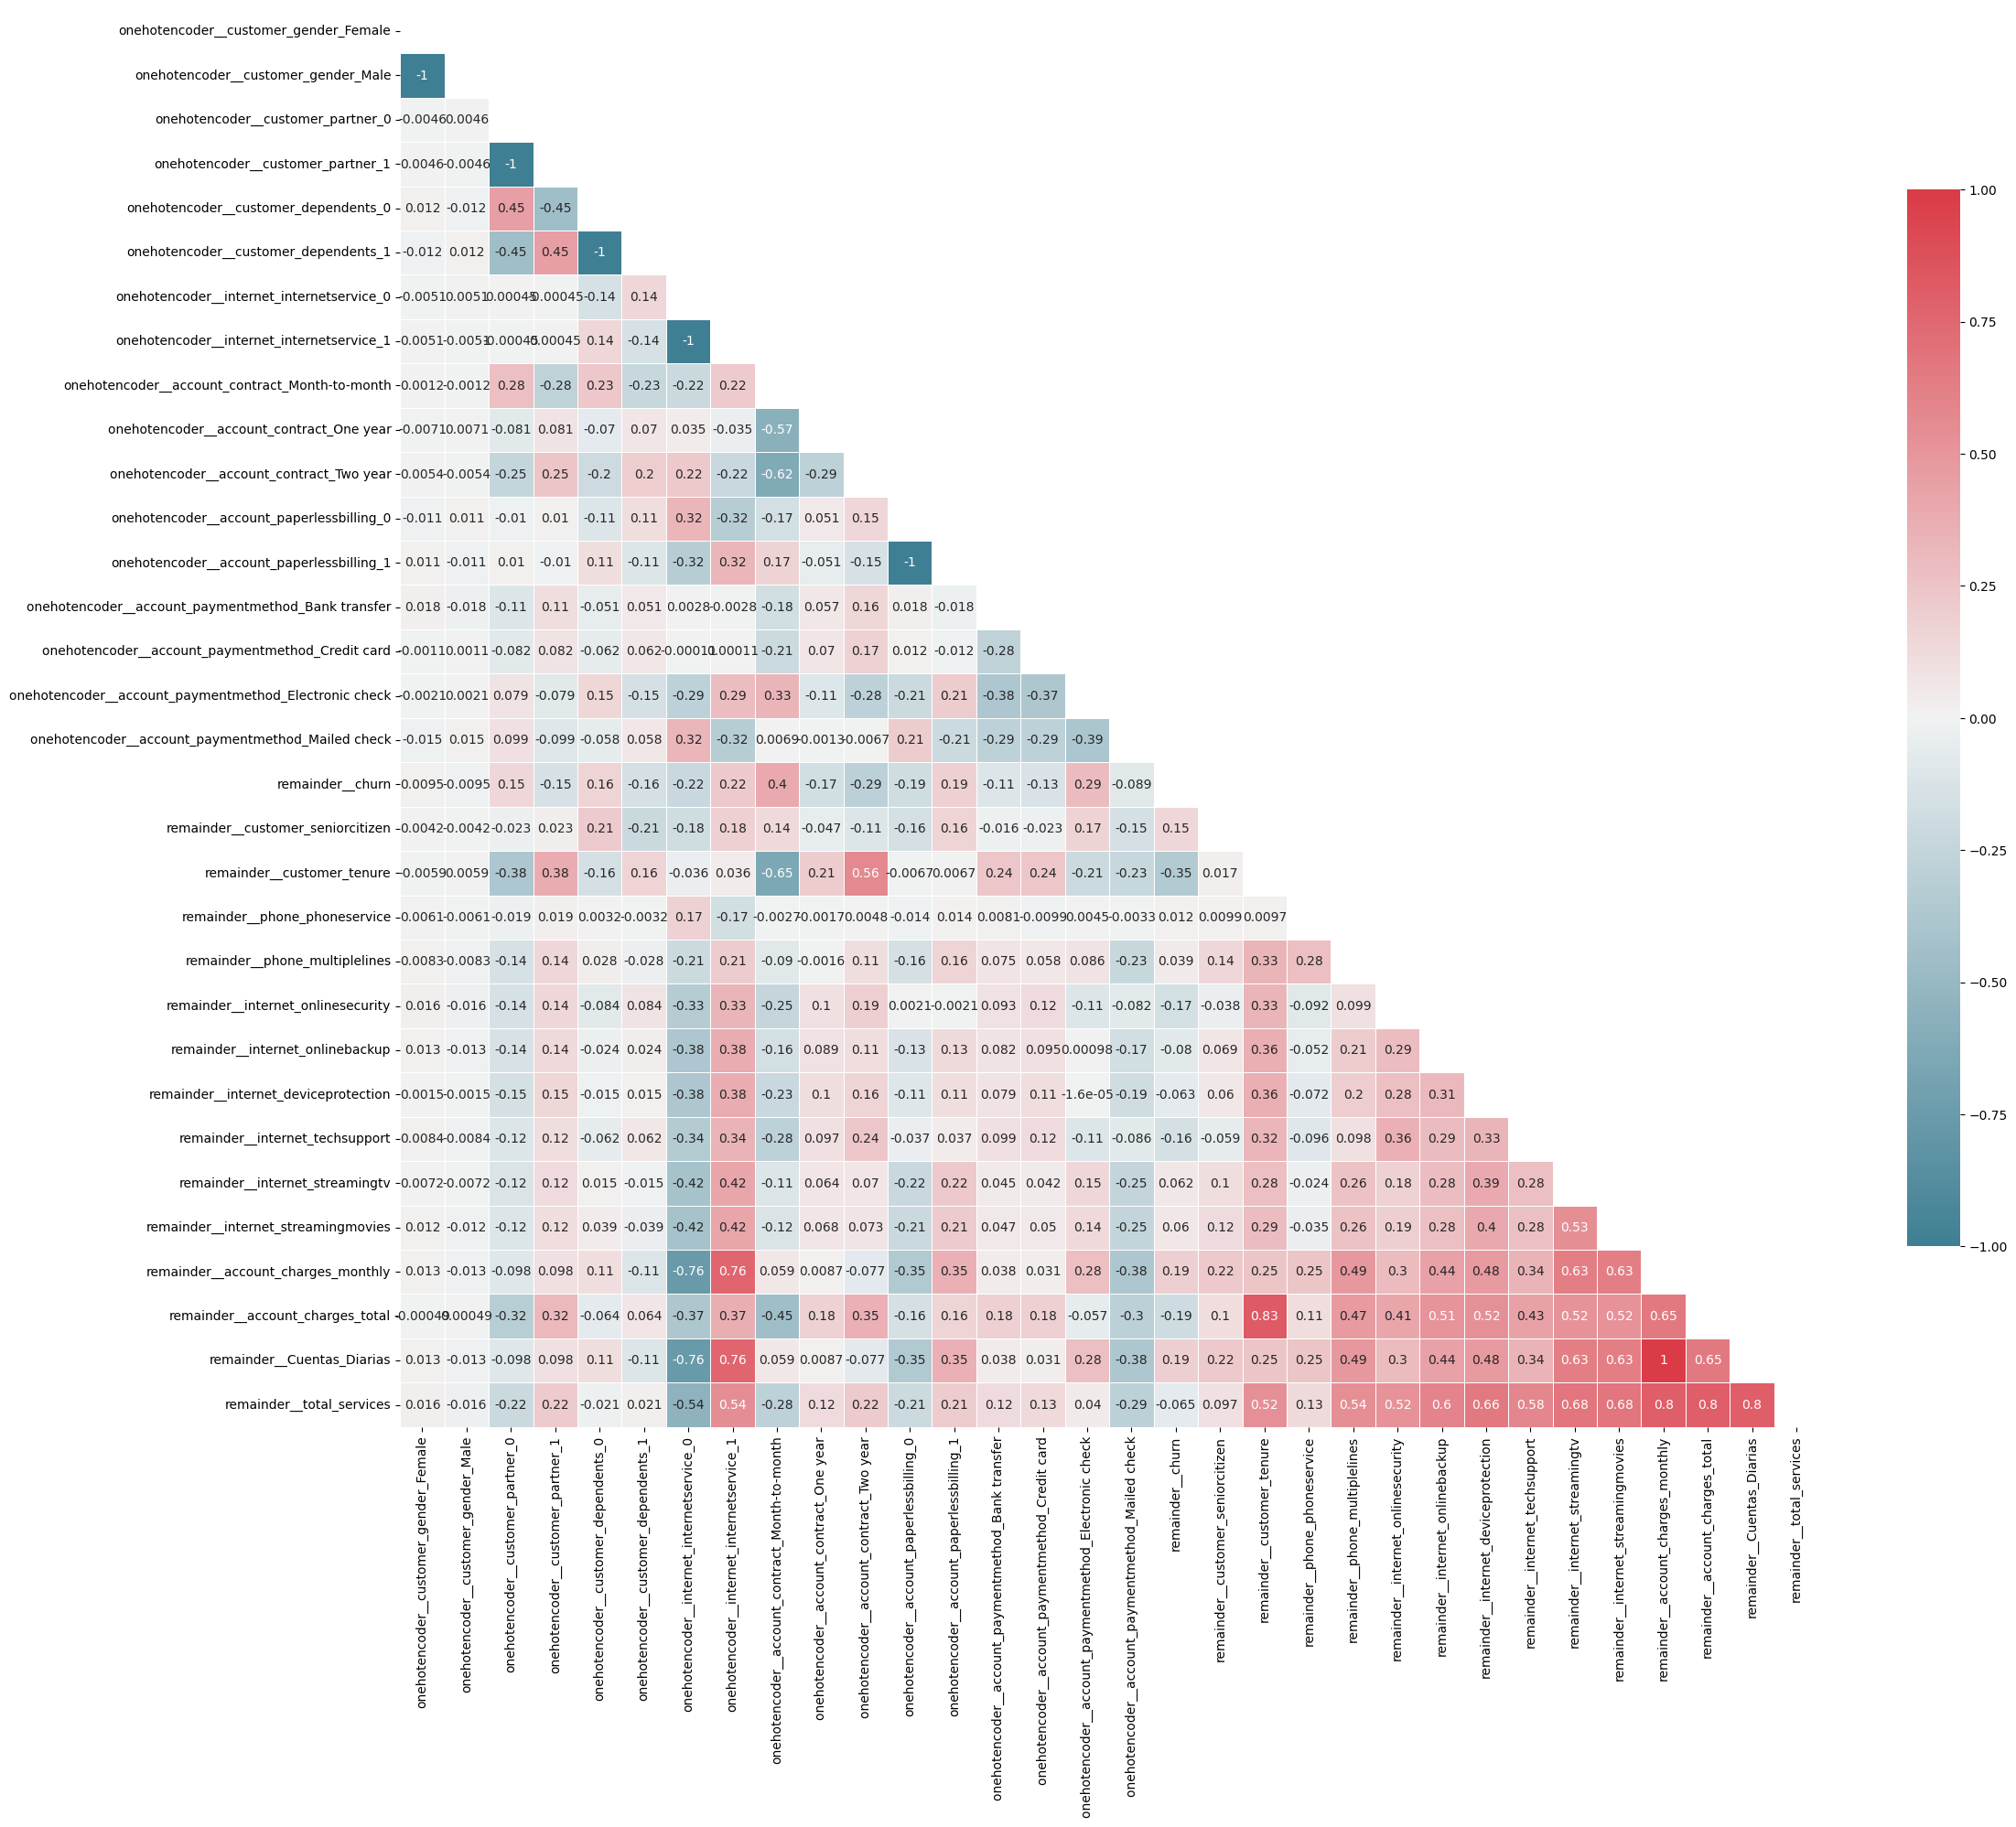

In [49]:
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 30))

# Generar el mapa de calor (heatmap)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Mostrar el mapa de calor (heatmap)
plt.show()

## **Análisis Dirigido**

In [50]:
def ancho_bin(df, columna):
    # Calcula el percentil 75 (Q3) y el percentil 25 (Q1) de la columna
    q75, q25 = np.percentile(df[columna], [75, 25])

    # Calcula el rango intercuartílico (IQR), que es Q3 - Q1
    iqr = q75 - q25

    # Aplica la fórmula de Freedman-Diaconis para calcular el ancho óptimo del bin:
    # ancho = 2 * IQR / (n^(1/3)), donde n es el número de datos elevado a la
    # -1/3, negativo porque se aplica la raiz al denominador
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)

    # Retorna el ancho calculado
    return ancho

In [51]:
binwidth = ancho_bin(datos_OneHotEncoder,'remainder__total_services')

### **Total_services segun Churn**

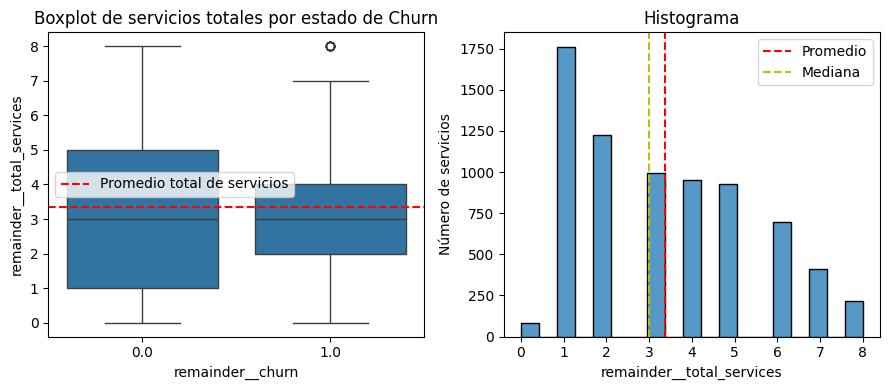

In [52]:
# Calcular el promedio de total_services
total_services_media = datos_OneHotEncoder['remainder__total_services'].mean()
total_servicios_mediana = datos_OneHotEncoder['remainder__total_services'].median()

# Crear figura y ejes
fig, ax = plt.subplots(1,2,figsize=(9,4))

# Hacer el boxplot: comparar total_services entre clientes que se fueron (1) y no se fueron (0)
sns.boxplot(data=datos_OneHotEncoder, x='remainder__churn', y='remainder__total_services', ax=ax[0])

# Título y línea del promedio
ax[0].set_title('Boxplot de servicios totales por estado de Churn')
ax[0].axhline(y=total_services_media, color='r', linestyle='--', label='Promedio total de servicios')
ax[0].legend()

sns.histplot(data=datos_OneHotEncoder, x='remainder__total_services', ax=ax[1], binwidth=binwidth)
plt.ylabel('Número de servicios')
plt.grid(False)
ax[1].set_title('Histograma')
ax[1].axvline(x=total_services_media, color='r', linestyle='--', label='Promedio')
ax[1].axvline(x=total_servicios_mediana, color='y', linestyle='--', label='Mediana')
ax[1].legend()

plt.tight_layout()

plt.show()

### **Account_charges_total por churn**

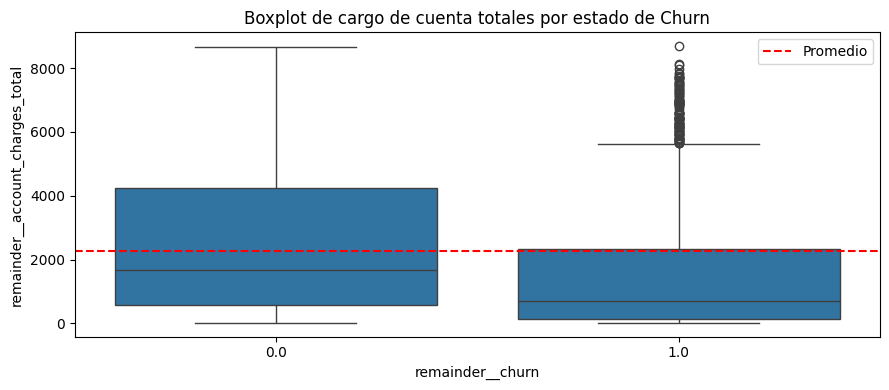

In [53]:
# Calcular el promedio de total_services
total_services_media = datos_OneHotEncoder['remainder__account_charges_total'].mean()

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(9,4))

# Hacer el boxplot: comparar total_services entre clientes que se fueron (1) y no se fueron (0)
sns.boxplot(data=datos_OneHotEncoder, x='remainder__churn', y='remainder__account_charges_total', ax=ax)

# Título y línea del promedio
ax.set_title('Boxplot de cargo de cuenta totales por estado de Churn')
ax.axhline(y=total_services_media, color='r', linestyle='--', label='Promedio')
ax.legend()

plt.tight_layout()

plt.show()

### **Internet_techsupport segun Churn**

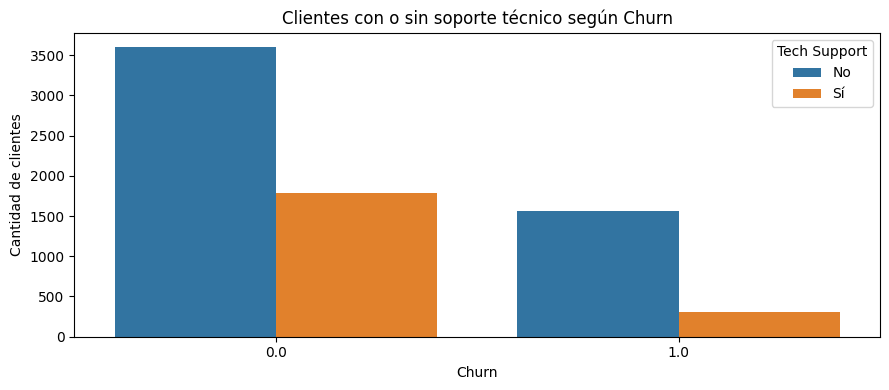

In [54]:
# Calcular el promedio de total_services
total_services_media = datos_OneHotEncoder['remainder__internet_techsupport'].mean()

fig, ax = plt.subplots(figsize=(9, 4))

sns.countplot(data=datos_OneHotEncoder, x='remainder__churn', hue='remainder__internet_techsupport', ax=ax)

ax.set_title('Clientes con o sin soporte técnico según Churn')
ax.set_xlabel('Churn')
ax.set_ylabel('Cantidad de clientes')
ax.legend(title='Tech Support', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()

### **Internet_deviceproteccion segun churn**

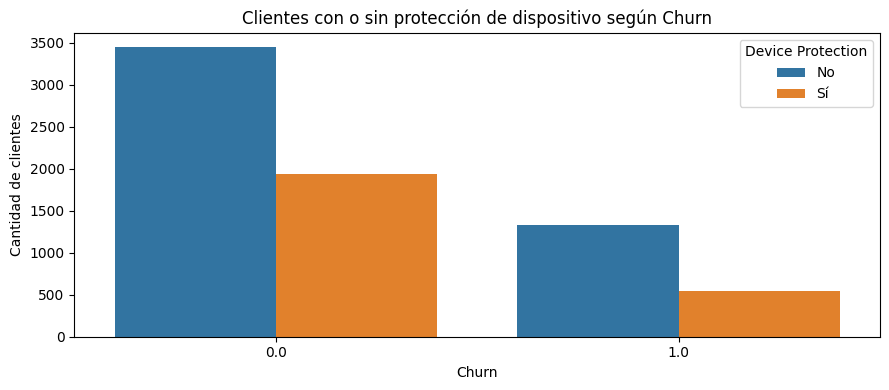

In [55]:
fig, ax = plt.subplots(figsize=(9, 4))

sns.countplot(data=datos_OneHotEncoder, x='remainder__churn', hue='remainder__internet_deviceprotection', ax=ax)

ax.set_title('Clientes con o sin protección de dispositivo según Churn')
ax.set_xlabel('Churn')
ax.set_ylabel('Cantidad de clientes')
ax.legend(title='Device Protection', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()

### **Internet_onlinebackup segun churn**

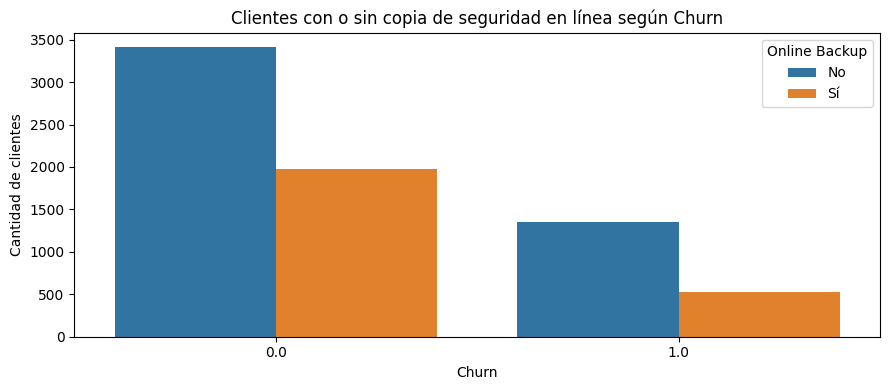

In [56]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(9, 4))

# Crear el gráfico de conteo
sns.countplot(
    data=datos_OneHotEncoder,
    x='remainder__churn',
    hue='remainder__internet_onlinebackup',
    ax=ax
)

# Título y etiquetas
ax.set_title('Clientes con o sin copia de seguridad en línea según Churn')
ax.set_xlabel('Churn')
ax.set_ylabel('Cantidad de clientes')

# Leyenda personalizada
ax.legend(title='Online Backup', labels=['No', 'Sí'])

# Ajustes finales
plt.tight_layout()
plt.show()

### **internet_onlinesecurity segun churn**

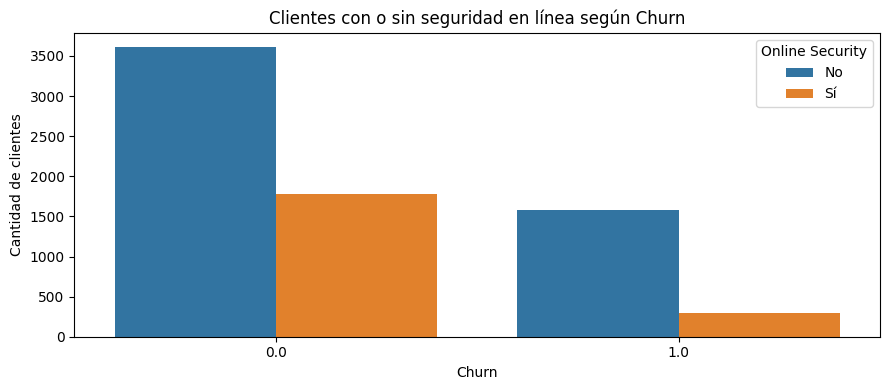

In [57]:
# Crear figura y eje
fig, ax = plt.subplots(figsize=(9, 4))

# Gráfico de conteo
sns.countplot(
    data=datos_OneHotEncoder,
    x='remainder__churn',
    hue='remainder__internet_onlinesecurity',
    ax=ax
)

# Título y etiquetas
ax.set_title('Clientes con o sin seguridad en línea según Churn')
ax.set_xlabel('Churn')
ax.set_ylabel('Cantidad de clientes')

# Leyenda
ax.legend(title='Online Security', labels=['No', 'Sí'])

# Ajustes finales
plt.tight_layout()
plt.show()

### **Customer_ternure segun churn**

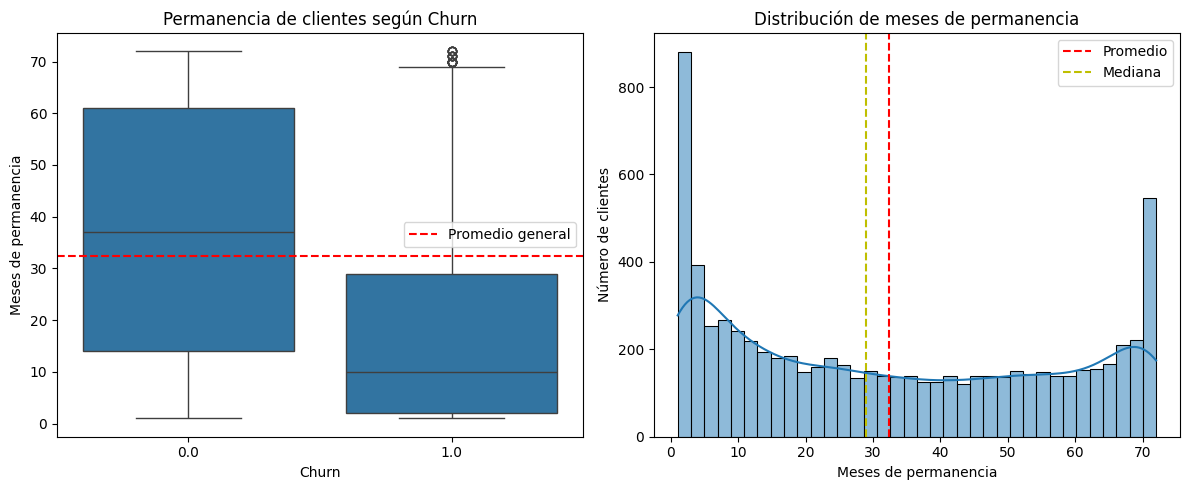

In [58]:
# Calcular medidas estadísticas
tenure_promedio = datos_OneHotEncoder['remainder__customer_tenure'].mean()
tenure_mediana = datos_OneHotEncoder['remainder__customer_tenure'].median()

# Crear figura y ejes
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Boxplot
sns.boxplot(
    data=datos_OneHotEncoder,
    x='remainder__churn',
    y='remainder__customer_tenure',
    ax=ax[0]
)
ax[0].set_title('Permanencia de clientes según Churn')
ax[0].set_xlabel('Churn')
ax[0].set_ylabel('Meses de permanencia')
ax[0].axhline(y=tenure_promedio, color='r', linestyle='--', label='Promedio general')
ax[0].legend()

# Gráfico 2: Histograma
sns.histplot(
    data=datos_OneHotEncoder,
    x='remainder__customer_tenure',
    kde=True,
    ax=ax[1],
    binwidth=2
)
ax[1].set_title('Distribución de meses de permanencia')
ax[1].set_xlabel('Meses de permanencia')
ax[1].set_ylabel('Número de clientes')
ax[1].axvline(x=tenure_promedio, color='r', linestyle='--', label='Promedio')
ax[1].axvline(x=tenure_mediana, color='y', linestyle='--', label='Mediana')
ax[1].legend()

# Ajustar diseño
plt.tight_layout()
plt.show()

## **Verificación de la Proporción de Cancelación (Churn)**

In [59]:
datos_OneHotEncoder['remainder__churn'].value_counts(normalize=True)

,proportion
remainder__churn,
0.0,0.74242
1.0,0.25758


Las proporciones estan algo desiguales

# **Modelo predictivo**

## **Separación de Datos**

In [60]:
X = datos_OneHotEncoder.drop(['remainder__churn'], axis=1)
y = datos_OneHotEncoder['remainder__churn']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,         # 20% para prueba
    stratify=y,            # mantiene proporciones de clases
    random_state=42        # para reproducibilidad
)

## **Normalizacon / Estandarizacion**

Solo para modelos basados en distancia, como KNN, SVM, Regresión Logística y Redes Neuronales, requieren este preprocesamiento. Por otro lado, modelos basados en árboles, como Decision Tree, Random Forest y XGBoost, no son sensibles a la escala de los datos.

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Balanceo de clases**

In [63]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# **Creación de Modelos**

## **Modelo Random Forest Classifier**

In [64]:
modelo_random_forest = RandomForestClassifier(max_depth=5, random_state=42)
modelo_random_forest.fit(X_train, y_train)

y_predict = modelo_random_forest.predict(X_test)

In [65]:
print("Accuracy:", accuracy_score(y_test, y_predict))
print("Precision:", precision_score(y_test, y_predict))
print("Recall:", recall_score(y_test, y_predict))
print("F1 Score:", f1_score(y_test, y_predict))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_predict))
print("Reporte completo:\n", classification_report(y_test, y_predict))

matriz_confusion = confusion_matrix(y_test, y_predict)

Accuracy: 0.7926997245179064
Precision: 0.681592039800995
Recall: 0.3663101604278075
F1 Score: 0.4765217391304348
Matriz de confusión:
 [[1014   64]
 [ 237  137]]
Reporte completo:
               precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1078
         1.0       0.68      0.37      0.48       374

    accuracy                           0.79      1452
   macro avg       0.75      0.65      0.67      1452
weighted avg       0.78      0.79      0.77      1452



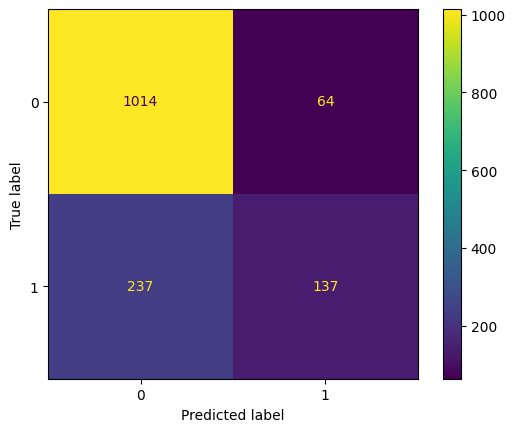

In [66]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion)
visualizacion.plot(); # Con el ; nos ahorramos traer matplotlib y nos ahorramos tener que poner plt.show()

In [67]:
importancias_random_forest = modelo_random_forest.feature_importances_
importancias_random_forest

array([0.00103244, 0.00084398, 0.00339777, 0.0042125 , 0.00379416,
       0.00489386, 0.04549994, 0.02673701, 0.19736482, 0.02792223,
       0.06024549, 0.01878544, 0.01782272, 0.0014629 , 0.00226202,
       0.09290515, 0.003403  , 0.00555405, 0.16794119, 0.00133317,
       0.0021298 , 0.02931361, 0.00588694, 0.00173841, 0.02680263,
       0.00368479, 0.00294844, 0.07015227, 0.08277054, 0.07469502,
       0.01246371])

In [68]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importances': (importancias_random_forest * 100).round(2)}).sort_values('importances', ascending=False)
feature_importances

,feature,importances
8,onehotencoder__account_contract_Month-to-month,19.74
18,remainder__customer_tenure,16.79
15,onehotencoder__account_paymentmethod_Electroni...,9.29
28,remainder__account_charges_total,8.28
29,remainder__Cuentas_Diarias,7.47
27,remainder__account_charges_monthly,7.02
10,onehotencoder__account_contract_Two year,6.02
6,onehotencoder__internet_internetservice_0,4.55
21,remainder__internet_onlinesecurity,2.93
9,onehotencoder__account_contract_One year,2.79


## **Modelo XGBoost**

In [69]:
modelo_xgb = XGBClassifier(
    max_depth=5,        # Profundidad de los árboles
    learning_rate=0.1,  # Tasa de aprendizaje
    n_estimators=100,   # Número de árboles
    subsample=0.8,      # Submuestreo (para regularización)
    colsample_bytree=0.8,  # Submuestreo de columnas
    use_label_encoder=False,  # Evitar warnings de versiones antiguas
    eval_metric='logloss',    # Métrica de evaluación
    random_state=42
)

In [70]:
# Entrenar el modelo
modelo_xgb.fit(X_train, y_train)

# Predecir
y_pred = modelo_xgb.predict(X_test)

In [71]:
# Evaluar
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte completo:\n", classification_report(y_test, y_pred))

matriz_confusion = confusion_matrix(y_test, y_pred)

Accuracy: 0.7940771349862259
Precision: 0.6288659793814433
Recall: 0.4893048128342246
F1 Score: 0.5503759398496241
Matriz de confusión:
 [[970 108]
 [191 183]]
Reporte completo:
               precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1078
         1.0       0.63      0.49      0.55       374

    accuracy                           0.79      1452
   macro avg       0.73      0.69      0.71      1452
weighted avg       0.78      0.79      0.79      1452



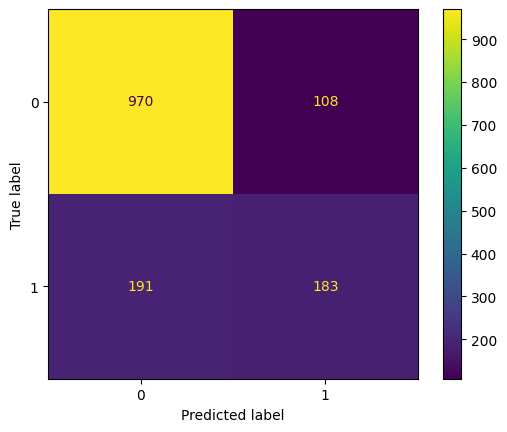

In [72]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion)
visualizacion.plot();

## **Variables importantes**

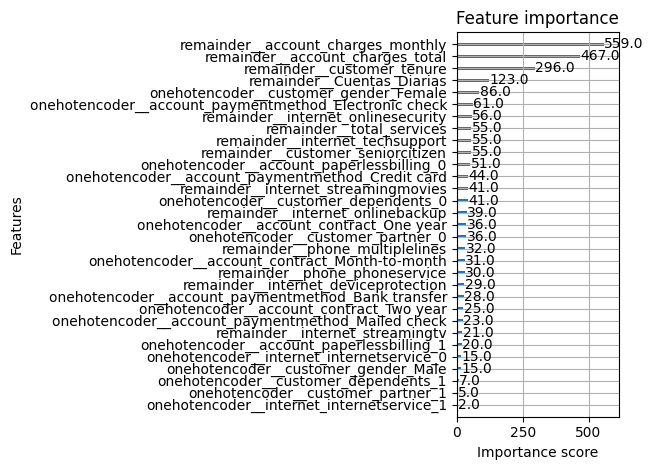

In [73]:
plot_importance(modelo_xgb)
plt.tight_layout()
plt.show()

## **Hiperparametros**

In [74]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [75]:
grid_search = GridSearchCV(
    estimator=modelo_xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1      # Usa todos los núcleos disponibles para acelerar
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [76]:
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Usar el mejor modelo
mejor_modelo = grid_search.best_estimator_

# Predicciones
y_pred = mejor_modelo.predict(X_test)

# Evaluación
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

matriz_confusion = confusion_matrix(y_test, y_pred)

Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Matriz de confusión:
 [[970 108]
 [194 180]]
Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.83      0.90      0.87      1078
         1.0       0.62      0.48      0.54       374

    accuracy                           0.79      1452
   macro avg       0.73      0.69      0.70      1452
weighted avg       0.78      0.79      0.78      1452



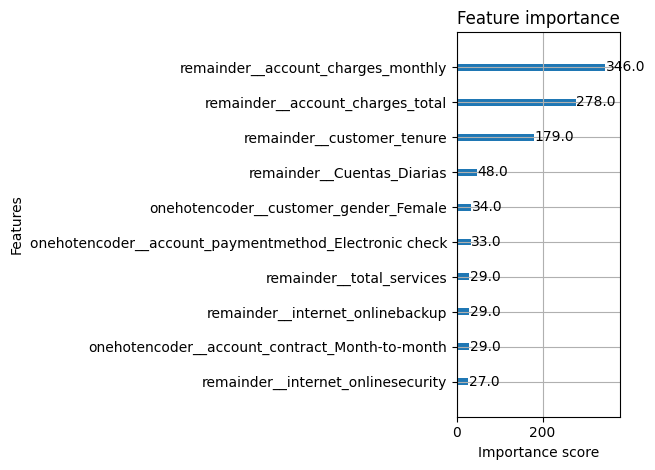

In [77]:
plot_importance(mejor_modelo, max_num_features=10)
plt.tight_layout()
plt.show()

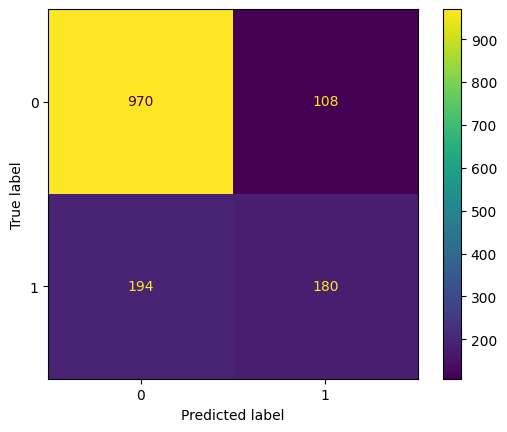

In [78]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion)
visualizacion.plot();

## **Modelo KNN**

In [79]:
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

In [80]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='binary'))  # Usa 'macro' si es multiclase
print("Recall:", recall_score(y_test, y_pred, average='binary'))
print("F1 Score:", f1_score(y_test, y_pred, average='binary'))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte completo:\n", classification_report(y_test, y_pred))

matriz_confusion = confusion_matrix(y_test, y_pred)

Accuracy: 0.762396694214876
Precision: 0.5498281786941581
Recall: 0.42780748663101603
F1 Score: 0.48120300751879697
Matriz de confusión:
 [[947 131]
 [214 160]]
Reporte completo:
               precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      1078
         1.0       0.55      0.43      0.48       374

    accuracy                           0.76      1452
   macro avg       0.68      0.65      0.66      1452
weighted avg       0.75      0.76      0.75      1452



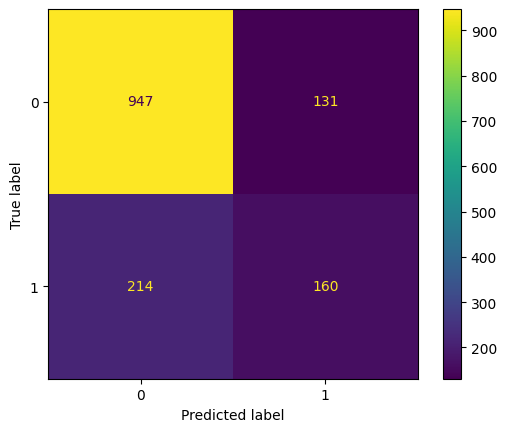

In [81]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion)
visualizacion.plot();

## **Hiperparametros KNN**

In [82]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [83]:
# Aplicar búsqueda en grilla con validación cruzada
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mejor modelo ya entrenado
best_knn = grid_search.best_estimator_

Mejores parámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}


In [84]:
y_pred = best_knn.predict(X_test)
print("Accuracy final:", accuracy_score(y_test, y_pred))

Accuracy final: 0.7858126721763086


In [85]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='binary'))  # Usa 'macro' si es multiclase
print("Recall:", recall_score(y_test, y_pred, average='binary'))
print("F1 Score:", f1_score(y_test, y_pred, average='binary'))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte completo:\n", classification_report(y_test, y_pred))

matriz_confusion = confusion_matrix(y_test, y_pred)

Accuracy: 0.7858126721763086
Precision: 0.6329113924050633
Recall: 0.40106951871657753
F1 Score: 0.4909983633387889
Matriz de confusión:
 [[991  87]
 [224 150]]
Reporte completo:
               precision    recall  f1-score   support

         0.0       0.82      0.92      0.86      1078
         1.0       0.63      0.40      0.49       374

    accuracy                           0.79      1452
   macro avg       0.72      0.66      0.68      1452
weighted avg       0.77      0.79      0.77      1452



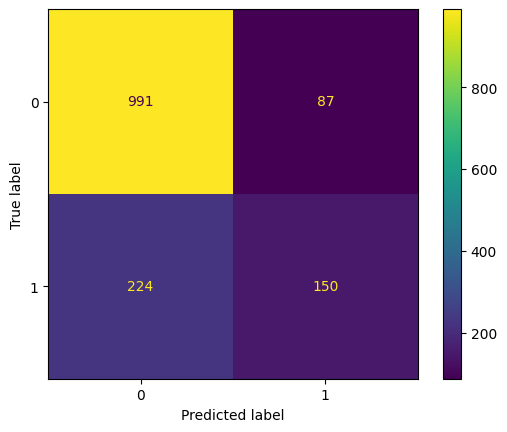

In [86]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion)
visualizacion.plot();

## **Exportar modelo XGBoost**

In [87]:
try:
  with open('championXGBoost.pkl', 'wb') as file:
    pickle.dump(mejor_modelo, file)
  print('modelo serializado con exito')
except Exception as e:
  print('Se presento un erro al almacenar el modelo', str(e))

modelo serializado con exito


## **Exportando modelo RandomForestClassifier**

In [88]:
try:
  with open('championRandomForestClassifier.pkl', 'wb') as file:
    pickle.dump(modelo_random_forest, file)
  print('modelo serializado con exito')
except Exception as e:
  print('Se presento un erro al almacenar el modelo', str(e))

modelo serializado con exito
